# LendSmart Credit Risk Analysis — LDA vs. QDA
**Hecho por:** 
- Aquiba Samuel Benarroch Serfaty - A01784240
- Edgar Samuel Oropeza García
- Uziel Heredia Estrada

**Fecha:** 2025/11/06 

Este notebook desarrolla el caso de riesgo crediticio para LendSmart, comparando LDA y QDA para predecir loan_status y seleccionar el mejor modelo.


 ## Section 1 - Protect setup & data loading
 #### Importar libererias

In [26]:
# Reproducibilidad y librerías base
import os, sys, platform, warnings, math, random
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)


In [27]:
df = pd.read_csv("credit_risk_data-1.csv")

display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   application_id         2500 non-null   object 
 1   application_date       2500 non-null   object 
 2   loan_amount            2500 non-null   float64
 3   annual_income          2500 non-null   float64
 4   employment_years       2500 non-null   float64
 5   job_stability_score    2500 non-null   float64
 6   credit_score           2500 non-null   int64  
 7   credit_utilization     2500 non-null   float64
 8   payment_history_score  2500 non-null   float64
 9   open_credit_lines      2500 non-null   int64  
 10  debt_to_income_ratio   2500 non-null   float64
 11  savings_ratio          2500 non-null   float64
 12  asset_value            2500 non-null   float64
 13  age                    2500 non-null   int64  
 14  education_level        2500 non-null   object 
 15  mari

None

,loan_amount,annual_income,employment_years,job_stability_score,credit_score,credit_utilization,payment_history_score,open_credit_lines,debt_to_income_ratio,savings_ratio,asset_value,age,residential_stability,loan_status
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,155716.305344,67707.807596,6.675640,0.634643,681.728400,0.358176,0.740733,3.451600,0.408094,0.320784,175666.741236,42.045600,6.023200,0.265600
std,149605.357952,27302.931731,3.488021,0.293276,88.683309,0.289995,0.285966,2.083793,0.224736,0.192079,182652.568930,12.092395,3.205397,0.441741
min,5000.000000,15000.000000,0.000000,0.011000,334.000000,0.004000,0.029000,0.000000,0.009000,0.000000,550.630000,18.000000,0.000000,0.000000
25%,42984.517500,47475.317500,4.000000,0.375500,642.750000,0.131000,0.517500,2.000000,0.228000,0.161000,49513.082500,34.000000,3.600000,0.000000
50%,97054.315000,66963.475000,6.700000,0.752000,700.000000,0.246000,0.880500,3.000000,0.359000,0.327000,121018.750000,42.000000,5.900000,0.000000
75%,213214.992500,87347.642500,9.300000,0.866000,743.000000,0.592250,0.956000,5.000000,0.565000,0.464000,235513.902500,50.000000,8.400000,1.000000
max,500000.000000,149929.960000,19.300000,0.999000,850.000000,0.998000,1.000000,11.000000,0.979000,0.893000,1000000.000000,75.000000,16.400000,1.000000


##  Resumen inicial

El dataset contiene información de 2,500 solicitudes de préstamo procesadas por LendSmart entre 2022 y 2024.  
Cada registro representa una aplicación de crédito individual con variables demográficas, financieras y de historial crediticio.

**Principales grupos de variables:**
-  **Financieras:** loan_amount, annual_income, debt_to_income_ratio, savings_ratio, asset_value.
-  **Historial crediticio:** credit_score, credit_utilization, payment_history_score, open_credit_lines.
-  **Empleo y estabilidad:** employment_years, job_stability_score, residential_stability.
-  **Demográficas:** age, education_level, marital_status.
-  **Variable objetivo:** loan_status (0 = buen pagador, 1 = default).

## Section 2 - EDA


El objetivo del EDA es comprender la estructura, distribución y relaciones de las variables del dataset de riesgo crediticio de LendSmart, con el fin de:

1. Describir el comportamiento de los solicitantes de crédito (perfil financiero, demográfico y crediticio).
2. Comparar las características entre prestatarios “buenos” (loan_status = 0) y "malos" (loan_status = 1) para detectar patrones.
3. Identificar variables clave que podrían influir en el riesgo de default y que servirán como predictores principales en la modelización.




Tasa de default (loan_status=1): 26.56%


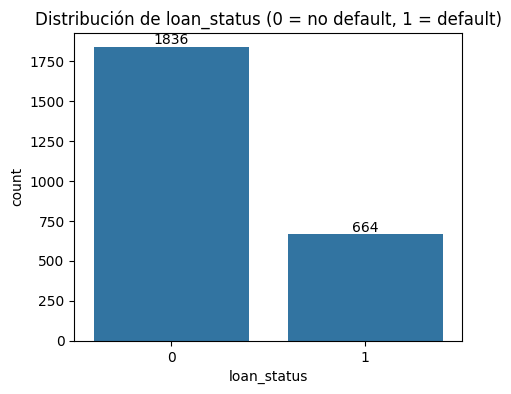

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribución del target
default_rate = df["loan_status"].mean()
print(f"Tasa de default (loan_status=1): {default_rate:.2%}")

fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(data=df, x="loan_status", ax=ax)
ax.set_title("Distribución de loan_status (0 = no default, 1 = default)")
ax.bar_label(ax.containers[0])
plt.show()


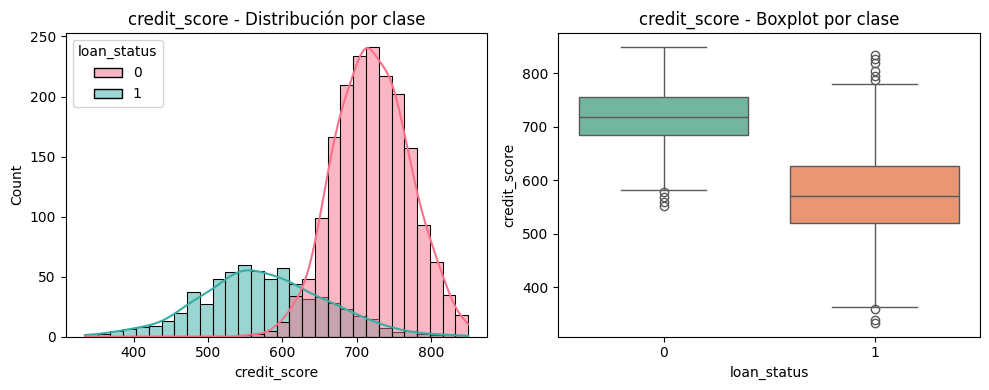

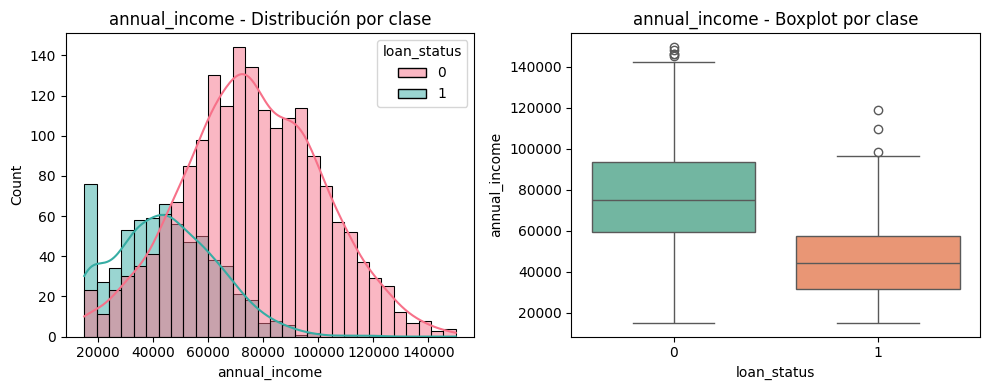

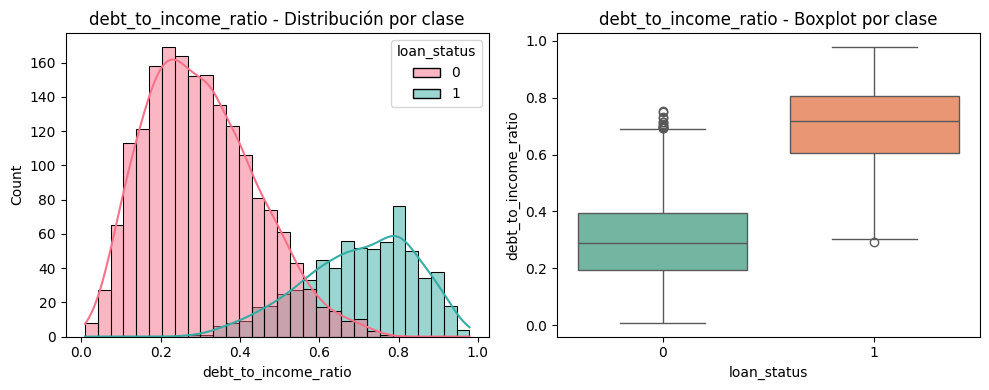

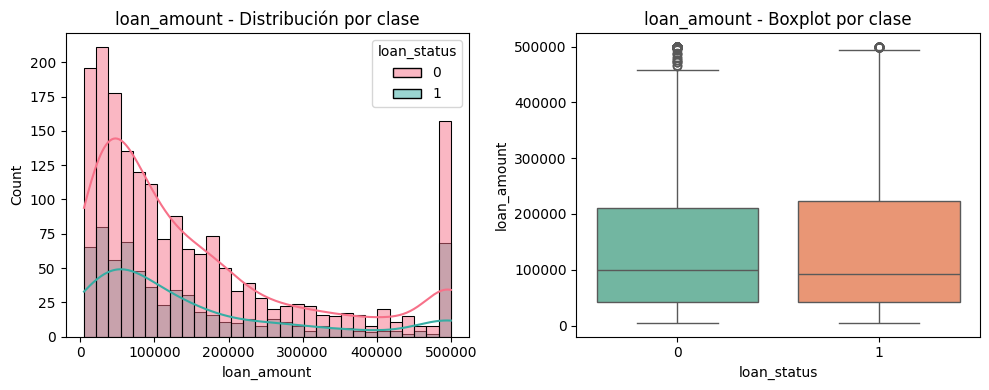

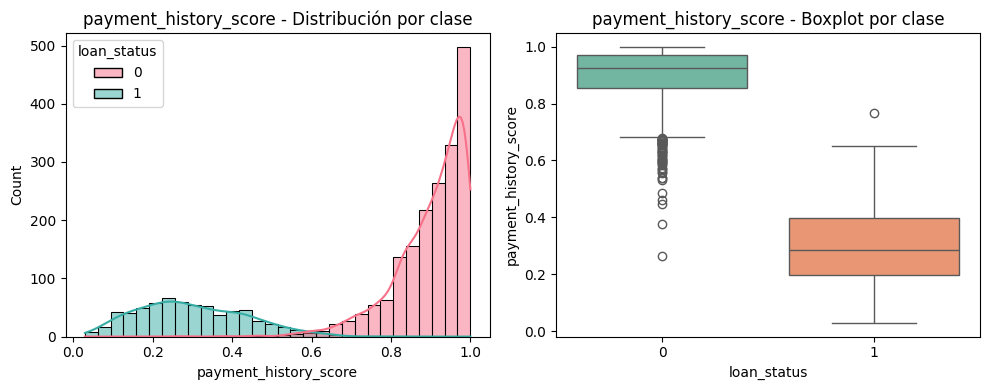

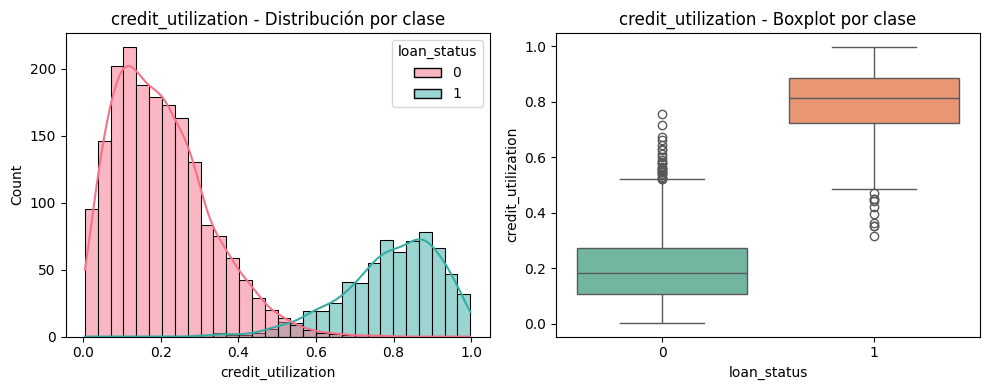

In [29]:
# Variables continuas

# Variables numéricas clave 
cont_vars = [
    "credit_score", "annual_income", "debt_to_income_ratio",
    "loan_amount", "payment_history_score", "credit_utilization"
]

# Histplot + boxplot por clase para cada variable
for col in cont_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(data=df, x=col, hue="loan_status", kde=True, ax=axes[0], palette="husl", bins=30)
    axes[0].set_title(f"{col} - Distribución por clase")

    sns.boxplot(data=df, x="loan_status", y=col, ax=axes[1], palette="Set2")
    axes[1].set_title(f"{col} - Boxplot por clase")

    plt.tight_layout()
    plt.show()


,mean_default_rate
education_level,
High School,0.560811
Associates,0.369128
Bachelors,0.154676
Masters,0.128959
Doctorate,0.048913


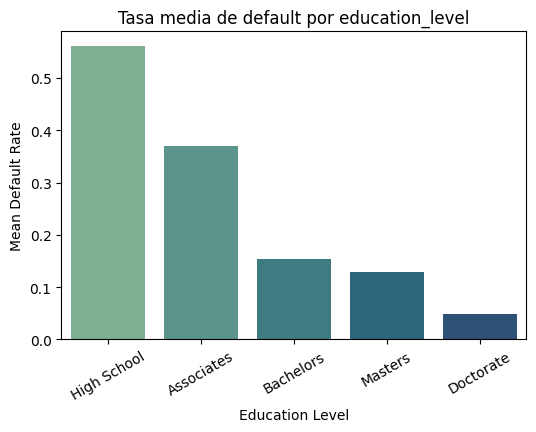

,mean_default_rate
marital_status,
Widowed,0.429412
Single,0.424138
Divorced,0.346241
Married,0.147216


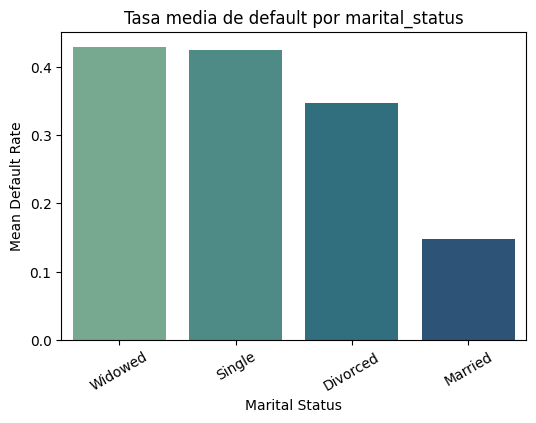

In [30]:
# Variables categóricas

cat_vars = ["education_level", "marital_status"]

for col in cat_vars:
    rate_by_cat = df.groupby(col)["loan_status"].mean().sort_values(ascending=False)
    display(rate_by_cat.to_frame("mean_default_rate"))

    plt.figure(figsize=(6,4))
    sns.barplot(x=rate_by_cat.index, y=rate_by_cat.values, palette="crest")
    plt.title(f"Tasa media de default por {col}")
    plt.ylabel("Mean Default Rate")
    plt.xlabel(col.replace("_", " ").title())
    plt.xticks(rotation=30)
    plt.show()


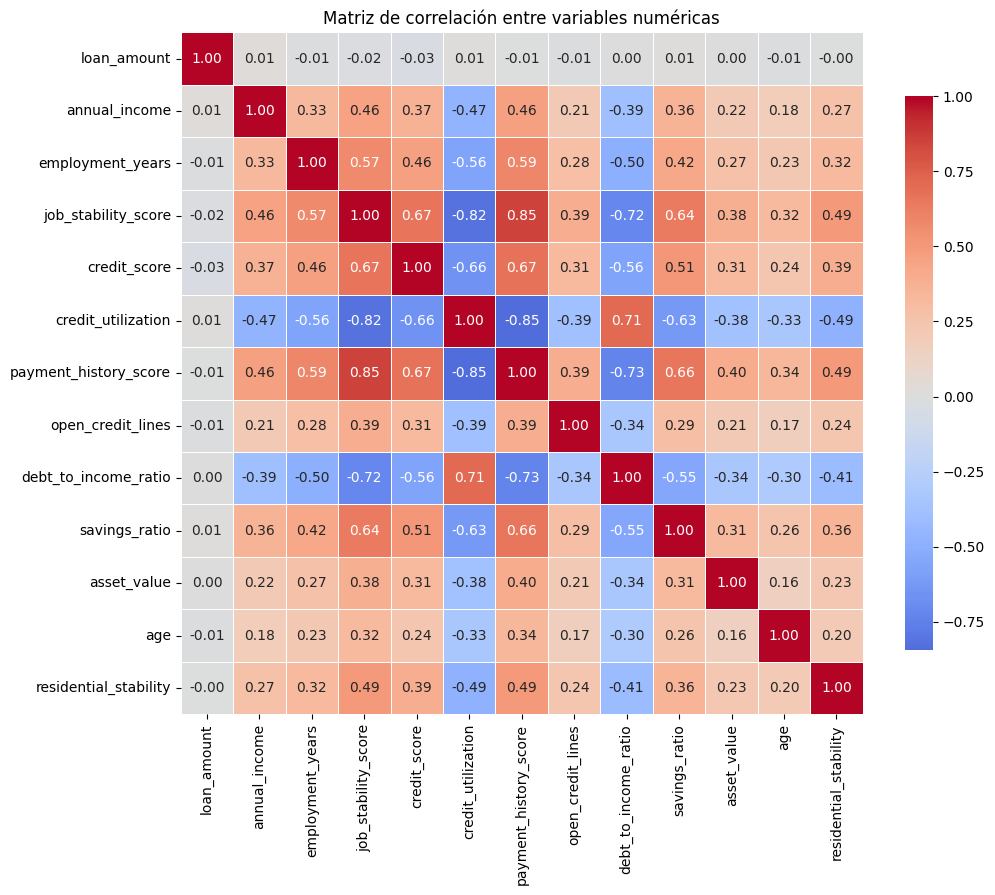

,Variable_1,Variable_2,Correlation,|Correlation|
35,job_stability_score,payment_history_score,0.848998,0.848998
50,credit_utilization,payment_history_score,-0.845028,0.845028
34,job_stability_score,credit_utilization,-0.817940,0.817940
58,payment_history_score,debt_to_income_ratio,-0.732091,0.732091
37,job_stability_score,debt_to_income_ratio,-0.716097,0.716097
52,credit_utilization,debt_to_income_ratio,0.714176,0.714176
43,credit_score,payment_history_score,0.674485,0.674485
33,job_stability_score,credit_score,0.666023,0.666023
59,payment_history_score,savings_ratio,0.659715,0.659715
42,credit_score,credit_utilization,-0.657600,0.657600


 Variables altamente correlacionadas (|r| > 0.8):


,Variable_1,Variable_2,Correlation,|Correlation|
35,job_stability_score,payment_history_score,0.848998,0.848998
50,credit_utilization,payment_history_score,-0.845028,0.845028
34,job_stability_score,credit_utilization,-0.817940,0.817940


In [31]:
# Correlaciones entre variables numéricas

# Seleccionamos solo las variables numéricas (sin IDs ni target)
num_df = df.select_dtypes(include=["float64", "int64"]).drop(columns=["loan_status"], errors="ignore")

# Matriz de correlación
corr_matrix = num_df.corr()

# Heatmap con anotaciones numéricas
plt.figure(figsize=(11,9))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,        # muestra los valores numéricos
    fmt=".2f",        
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Lista ordenada de correlaciones fuertes (sin duplicados)
#    Extraemos pares de variables con |r| > 0.7
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Variable_1", "Variable_2", "Correlation"]
corr_pairs["|Correlation|"] = corr_pairs["Correlation"].abs()
corr_pairs_sorted = corr_pairs.sort_values("|Correlation|", ascending=False)

display(corr_pairs_sorted.head(10))

# 3️ Si quieres solo los pares con |r| > 0.8 (multicolinealidad alta)
high_corr = corr_pairs_sorted[corr_pairs_sorted["|Correlation|"] > 0.8]
if not high_corr.empty:
    print(" Variables altamente correlacionadas (|r| > 0.8):")
    display(high_corr)
else:
    print(" No se encontraron correlaciones superiores a 0.8.")


## Section 3: Data Preprocessing

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Convertimos las variables categóricas (education_level, marital_status)
# en variables dummy (one-hot encoding), eliminando la primera categoría para evitar colinealidad.
df_encoded = pd.get_dummies(df, columns=["education_level", "marital_status"], drop_first=True)

# Eliminamos columnas no predictoras (application_id, application_date)
X = df_encoded.drop(columns=["loan_status", "application_id", "application_date"], errors="ignore")
y = df_encoded["loan_status"]

# Separamos en train/test con 20% para test y semilla 42 para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamaños:")
print("X_train:", X_train.shape, " | X_test:", X_test.shape)
print("y_train:", y_train.shape, " | y_test:", y_test.shape)

# Estandarizamos únicamente las variables numéricas (importante para LDA/QDA)
scaler = StandardScaler()

# Fit SOLO con el set de entrenamiento, luego transform ambos
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_scaled.head()


Tamaños:
X_train: (2000, 20)  | X_test: (500, 20)
y_train: (2000,)  | y_test: (500,)


,loan_amount,annual_income,employment_years,job_stability_score,credit_score,credit_utilization,payment_history_score,open_credit_lines,debt_to_income_ratio,savings_ratio,asset_value,age,residential_stability,education_level_Bachelors,education_level_Doctorate,education_level_High School,education_level_Masters,marital_status_Married,marital_status_Single,marital_status_Widowed
2082,-0.707127,-0.178154,0.919011,-0.326186,0.353127,-0.640044,0.263574,-0.214963,-0.745375,1.188857,-0.040578,-0.250595,-0.915221,-0.704987,-0.281657,-0.460566,-0.466933,0.944536,-0.546536,-0.271178
1319,0.106011,1.672016,0.516843,0.998273,0.408670,-0.474465,0.692694,0.267558,-0.465969,1.016469,0.531191,1.419484,-0.156777,-0.704987,-0.281657,-0.460566,2.141633,0.944536,-0.546536,-0.271178
1569,-0.982116,-0.362805,1.981882,0.452105,0.664169,-0.388225,0.263574,-1.180007,1.112895,1.194081,-0.516328,-0.083587,-0.694008,1.418467,-0.281657,-0.460566,-0.466933,0.944536,-0.546536,-0.271178
1257,-0.836284,0.570386,1.550988,0.554511,1.075189,-1.071241,-0.025995,0.267558,1.055240,0.420948,-0.557864,2.421532,-0.061971,-0.704987,-0.281657,-0.460566,-0.466933,-1.058721,-0.546536,3.687620
2096,-0.811916,-0.118312,-0.201314,-0.401284,0.441996,-0.719384,0.731071,-0.697485,-0.776420,0.379157,-0.292794,0.834956,0.380455,-0.704987,3.550414,-0.460566,-0.466933,-1.058721,-0.546536,-0.271178


## Section 4: Statistical Assumption Testing (Written Discussion)

Antes de ajustar los modelos LDA y QDA, es importante discutir los supuestos estadísticos que diferencian ambas técnicas.

### 1. Normalidad Multivariante

Tanto LDA como QDA asumen que las variables predictoras siguen una distribución normal multivariante dentro de cada clase (buenos pagadores vs. incumplidores).

En la Sección 2, observamos que variables como `credit_score`, `employment_years` y `age` mostraron distribuciones razonablemente simétricas. Sin embargo, variables financieras como `annual_income`, `loan_amount` y `asset_value` presentaron asimetría positiva, lo cual es común en datos financieros.

Aunque la normalidad perfecta no se cumple en todas las variables, las distribuciones observadas son suficientemente razonables para aplicar análisis discriminante. 

---

### 2. Homogeneidad de Matrices de Covarianza

La diferencia entre los dos modelos es:

- LDA: Asume que ambas clases comparten la misma matriz de covarianza. 

- QDA: No asume homogeneidad de covarianzas. Cada clase puede tener su propia matriz de covarianza.

Los boxplots en la Sección 2 sugieren que los incumplidores (loan_status = 1) tienden a tener mayor variabilidad en variables como `debt_to_income_ratio` y `credit_utilization`, mientras que los buenos pagadores muestran distribuciones más concentradas. 

---

### 3. Hipótesis de Trabajo

Si las matrices de covarianza son desiguales entre las clases de buenos y malos pagadores, esperamos que QDA sea mejor que LDA en términos de precisión de clasificación, ya que QDA puede modelar estas diferencias estructurales de forma más flexible.

Sin embargo, si LDA captura suficientemente bien la separación entre clases, podría ser preferible por su simplicidad e interpretabilidad.

 ## Section 5: Model 1 - Linear Discriminant Analysis (LDA)

,abs_coef
payment_history_score,15.470813
job_stability_score,13.050045
credit_utilization,11.767166
debt_to_income_ratio,4.471488
credit_score,3.982636
savings_ratio,2.994385
employment_years,2.368588
residential_stability,1.699571
annual_income,1.585538
open_credit_lines,1.276691



Signo real de los 10 más influyentes (dirección del riesgo):


,coef
payment_history_score,-15.470813
job_stability_score,-13.050045
credit_utilization,11.767166
debt_to_income_ratio,4.471488
credit_score,-3.982636
savings_ratio,-2.994385
employment_years,-2.368588
residential_stability,-1.699571
annual_income,-1.585538
open_credit_lines,-1.276691


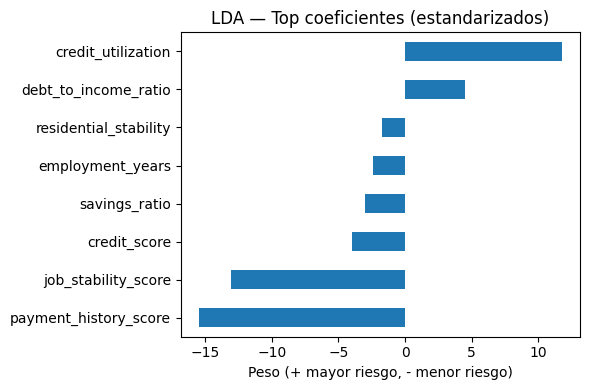

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# Coeficientes estandarizados (importancias lineales)
lda_coef = pd.Series(lda.coef_.ravel(), index=X_train_scaled.columns)
lda_top = lda_coef.abs().sort_values(ascending=False)

display(lda_top.head(10).to_frame("abs_coef"))
print("\nSigno real de los 10 más influyentes (dirección del riesgo):")
display(lda_coef.loc[lda_top.head(10).index].to_frame("coef"))

# Gráfico rápido (top 8 por valor absoluto)
plt.figure(figsize=(6,4))
lda_coef.loc[lda_top.head(8).index].sort_values().plot(kind="barh")
plt.title("LDA — Top coeficientes (estandarizados)")
plt.xlabel("Peso (+ mayor riesgo, - menor riesgo)")
plt.tight_layout()
plt.show()


## Resultados de LDA

**1. Variables más influyentes**
El análisis discriminante lineal estima un coeficiente para cada variable estandarizada, que representa su peso en la separación entre buenos (0) y malos pagadores (1).

| Ranking | Variable | Interpretación |
|----------|-----------|----------------|
| 1 | payment_history_score (-15.47) | Es el predictor más fuerte. Un puntaje alto en historial de pagos se asocia claramente con menor riesgo de default. |
| 2 | job_stability_score (-13.05) | La estabilidad laboral también tiene un gran peso negativo: mayor estabilidad menor probabilidad de incumplir. |
| 3 | credit_utilization (+11.77) | Aumenta el riesgo: prestatarios que usan gran parte de su crédito disponible son más propensos a incumplir. |
| 4 | debt_to_income_ratio (+4.47) | Una alta proporción deuda/ingreso incrementa la probabilidad de default. |
| 5 | credit_score (-3.98) | Un mayor puntaje crediticio se asocia con menor riesgo, como era esperado. |
| 6 | savings_ratio (-2.99) | Personas con mayor tasa de ahorro tienden a pagar mejor. |
| 7 | employment_years (-2.36) | Más años de empleo reducen el riesgo. |
| 8 | residential_stability (-1.70) | Mayor estabilidad residencial también es protectora. |
| 9 | annual_income (-1.56) | Ingreso más alto, menor riesgo. |
| 10 | open_credit_lines (-1.28) | Tener varias líneas de crédito abiertas reduce riesgo (posiblemente asociado con experiencia crediticia). |


-  **Coeficiente negativo** = variable protege contra default.  
-  **Coeficiente positivo** = variable aumenta el riesgo de default.


Los resultados son coherentes con la teoría crediticia: el riesgo se incrementa con mayor endeudamiento y uso de crédito, y se reduce con mejor historial, estabilidad y nivel de ingreso. 

El LDA parece captar adecuadamente la dirección del riesgo y es interpretable.


## Section 6: Model 2 - Quadratic Discriminant Analysis (QDA)

In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)


QuadraticDiscriminantAnalysis()

## Section 7: Model Evaluation & Comparison

=== Classification Report — LDA ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       367
           1      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500

=== Classification Report — QDA ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       367
           1      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500



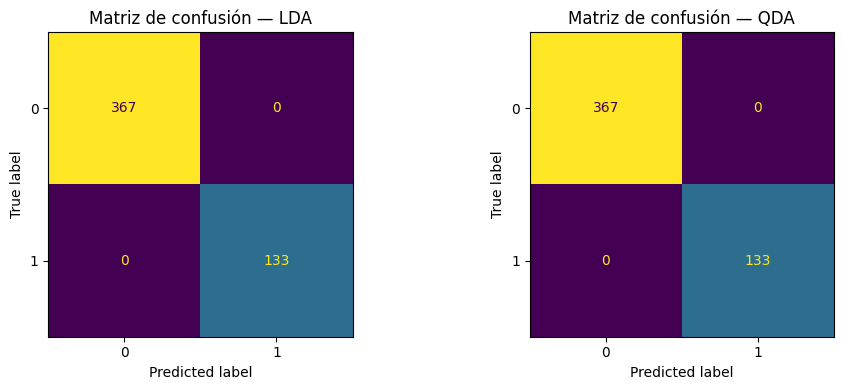

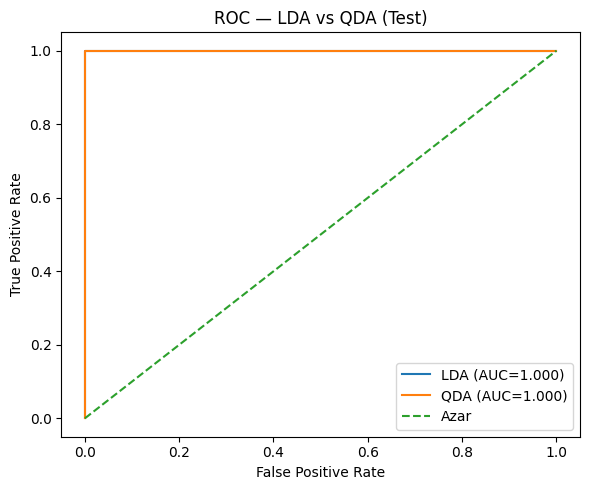

AUC LDA: 1.000 | AUC QDA: 1.000


In [35]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Predicciones
y_pred_lda = lda.predict(X_test_scaled)
y_pred_qda = qda.predict(X_test_scaled)

print("=== Classification Report — LDA ===")
print(classification_report(y_test, y_pred_lda, digits=3))

print("=== Classification Report — QDA ===")
print(classification_report(y_test, y_pred_qda, digits=3))

# Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lda, ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de confusión — LDA")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_qda, ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de confusión — QDA")
plt.tight_layout()
plt.show()

# ROC + AUC (mismo gráfico)
p_lda = lda.predict_proba(X_test_scaled)[:, 1]
p_qda = qda.predict_proba(X_test_scaled)[:, 1]

fpr_lda, tpr_lda, _ = roc_curve(y_test, p_lda)
fpr_qda, tpr_qda, _ = roc_curve(y_test, p_qda)
auc_lda, auc_qda = auc(fpr_lda, tpr_lda), auc(fpr_qda, tpr_qda)

plt.figure(figsize=(6,5))
plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC={auc_lda:.3f})")
plt.plot(fpr_qda, tpr_qda, label=f"QDA (AUC={auc_qda:.3f})")
plt.plot([0,1],[0,1],'--', label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — LDA vs QDA (Test)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUC LDA: {auc_lda:.3f} | AUC QDA: {auc_qda:.3f}")




**Resultados generales**

| Modelo | Accuracy | Recall (default=1) | Precision | AUC |
|---------|-----------|--------------------|------------|------|
| LDA | 1.000 | 1.000 | 1.000 | 1.000 |
| QDA | 1.000 | 1.000 | 1.000 | 1.000 |

Ambos modelos alcanzaron rendimiento perfecto en el conjunto de prueba:
- Matriz de confusión: 0 errores → todos los 500 casos clasificados correctamente.  
- Precision/Recall/F1 = 1.000 en ambas clases.

---

**Interpretación**

- Los resultados indican que las variables predictoras permiten una separación lineal casi perfecta entre prestatarios buenos y morosos.  
- El LDA logra esta separación utilizando una frontera lineal común de covarianza compartida.  
- El QDA, que permite covarianzas distintas, obtiene el mismo resultado, por lo que no añade mejora apreciable en este dataset.

---

**Conclusión**

Ambos modelos (LDA y QDA) logran una separación perfecta de clases, con métricas AUC = 1.000. 

Aunque los supuestos de homogeneidad de covarianza no se cumplen totalmente, el rendimiento de LDA es igual al de QDA.  

Por simplicidad e interpretabilidad, se recomienda mantener LDA como modelo final.


---


## Section 8: Technical Conclusion & Model Selection

Después de evaluar ambos modelos, Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrático (QDA), los resultados muestran que*ambos alcanzaron un desempeño perfecto en el conjunto de prueba:

- **Accuracy:** 1.000  
- **Recall:** 1.000  
- **Precision:** 1.000  
- **AUC:** 1.000  

Dado que ambos clasificadores obtuvieron exactamente los mismos resultados, la elección del modelo final se basa en criterios técnicos y de interpretabilidad, más que en diferencias de rendimiento.


Nosotros recomendamos seleccionar LDA (Linear Discriminant Analysis).

**Justificación:**
- LDA logró las mismas métricas de desempeño que QDA, clasificando correctamente todos los casos.  
- El modelo LDA asume una estructura de covarianza común, lo que lo hace más simple, estable y fácil de interpretar.  
- Dado que las clases presentan una clara separación lineal, LDA es suficiente para capturar las diferencias entre prestatarios sin aumentar la complejidad del modelo.

**Conclusión:**
Aunque tanto LDA como QDA obtuvieron resultados perfectos, se elige LDA por su mayor interpretabilidad, menor complejidad y rendimiento equivalente.  
